In [1]:


import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import subprocess
import os
import pickle
import sklearn

from sklearn.model_selection import train_test_split

from xgboost.sklearn import XGBClassifier




import keras.backend as K

from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
#from keras.applications.mobilenet import MobileNet
#from keras.applications.mobilenetv2 import MobileNetV2
#from keras.applications.nasnet import NASNetMobile,NASNetLarge
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,  img_to_array, load_img



from keras.applications.xception import Xception, preprocess_input

from keras.layers import Dense, GlobalAveragePooling2D,Flatten, BatchNormalization
from keras.layers import Input, Conv2D, MaxPooling2D, merge, Lambda,UpSampling2D, concatenate, Reshape, Dropout,Cropping2D,Activation
from keras.models import Model, load_model
import pandas as pd

from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import Callback


from keras import regularizers
#from dummyPy import OneHotEncoder
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

import itertools
import time


'''
src_1= 'drive/My Drive/kaggle/ali/'
src_2= 'train_sample_total/' #'train data directory'
src_3 = 'guangdong_round1_test_a_20180916/'  # test data directory
src_save = 'drive/My Drive/kaggle/ali/manu_big_data/'

'''

src_1= 'manu_big_data/'
src_2= '' #'train data directory'
src_3 = 'guangdong_round1_test_a_20180916/'  # test data directory
src_save = 'manu_big_data/new_era/'





with open(src_1+'failure_to_label.pkl', 'rb') as handle:
    label_dict = pickle.load(handle)
label_dict





Using TensorFlow backend.


{'正常': 0,
 '不导': 1,
 '擦花': 2,
 '横条': 3,
 '桔皮': 4,
 '漏底': 5,
 '碰伤': 6,
 '起坑': 7,
 '凸粉': 8,
 '涂层': 9,
 '脏点': 10,
 '其他': 11}

In [2]:
previous_file = pd.read_csv('test_submit_2_st_1.csv',header =None)

previous_file.columns = ['img','label']


In [3]:
previous_file.head()

,img,label
0,0.jpg,norm
1,1.jpg,norm
2,2.jpg,defect2
3,3.jpg,norm
4,4.jpg,defect10


In [4]:
test_pred = previous_file['label'].tolist()
test_failure_list = [t != 'norm' for t in  test_pred]
print (sum(test_failure_list))
test_failure_list[:10]

311


[False, False, True, False, True, False, True, True, False, True]

In [32]:

test2_data = np.load(src_save+'test_data_aug_small_for_2_gap.npy')
print (test2_data.shape)


test2_data_2 = test2_data[test_failure_list]    # test_data2 = defect list in test data set (later will make inferefing )
print (test2_data_2.shape)


#model = load_model(src_save+'2nd_stage_MobileNetV2_aug_1000.h5')
model = load_model(src_save+'gap_MobileNetV2_1st_final.h5')


pred_stage_2 = model.predict(test2_data_2)

#predictions_stage_1 = [round(value) for value in pred_stage_1]

print (pred_stage_2.shape)

pred_stage_2_2 = np.argmax(pred_stage_2,axis=1) + 1  # note 要加  1 回來 starts from 1 to12 (not 0 to 11)
print (pred_stage_2_2.shape)

print (pred_stage_2_2[:10])

(440, 8, 10, 1280)
(311, 8, 10, 1280)
(311, 11)
(311,)
[10  2  9 10  3  6  7 11 10 10]


In [33]:

# read test csv file
test_df = pd.read_csv(src_1+'test.csv')
test_df['label']= previous_file['label']

test_df.loc[test_df['label']!='norm','label']=20
test_df.loc[test_df['label']=='norm','label']=0
test_df

,img,label
0,0.jpg,0
1,1.jpg,0
2,2.jpg,20
3,3.jpg,0
4,4.jpg,20
5,5.jpg,0
6,6.jpg,20
7,7.jpg,20
8,8.jpg,0
9,9.jpg,20


In [34]:

'''
replace defect rows with 2nd staget prediction
'''
test_df_2 =  test_df['label']
test_df_2[test_df_2 == 20] = pred_stage_2_2


test_df['label'] = test_df_2

test_df.head()

,img,label
0,0.jpg,0
1,1.jpg,0
2,2.jpg,10
3,3.jpg,0
4,4.jpg,2


In [35]:


with open(src_1+'label_to_category.pkl', 'rb') as handle:
    label_to_category = pickle.load(handle)


test_df['label'].replace(label_to_category,inplace=True)
test_df

,img,label
0,0.jpg,norm
1,1.jpg,norm
2,2.jpg,defect10
3,3.jpg,norm
4,4.jpg,defect2
5,5.jpg,norm
6,6.jpg,defect9
7,7.jpg,defect10
8,8.jpg,norm
9,9.jpg,defect3


In [36]:

test_df.to_csv(src_save+'test_submit_aug_gap_1st_final.csv', header=False,index=False)

In [37]:

#try_df = pd.read_csv('test_submit_2_st_0925_verification.csv',header=None)
try_df = pd.read_csv(src_save+'test_submit_aug_gap_1st_final.csv',header=None)
try_df.columns = ['1','2']
try_df

,1,2
0,0.jpg,norm
1,1.jpg,norm
2,2.jpg,defect10
3,3.jpg,norm
4,4.jpg,defect2
5,5.jpg,norm
6,6.jpg,defect9
7,7.jpg,defect10
8,8.jpg,norm
9,9.jpg,defect3


In [38]:

#try_df_2 = pd.read_csv('test_submit_first_try_2_n.csv',header=None)
try_df_2 = pd.read_csv(src_save+'test_submit_aug_gap_1st.csv',header=None)
try_df_2.columns = ['3','4']
try_df_2.head()

try_df_3 = pd.concat([try_df, try_df_2], axis=1)
try_df_3
# Locat which originally not normal, but should be normal


,1,2,3,4
0,0.jpg,norm,0.jpg,norm
1,1.jpg,norm,1.jpg,norm
2,2.jpg,defect10,2.jpg,defect10
3,3.jpg,norm,3.jpg,norm
4,4.jpg,defect2,4.jpg,defect2
5,5.jpg,norm,5.jpg,norm
6,6.jpg,defect9,6.jpg,defect9
7,7.jpg,defect10,7.jpg,defect10
8,8.jpg,norm,8.jpg,norm
9,9.jpg,defect3,9.jpg,defect3


In [39]:


len (try_df_3[try_df_3['2'] != try_df_3['4']])  # total 55 different


0

Confusion matrix, without normalization
[[278   6]
 [  5 189]]






             precision    recall  f1-score   support

          0       0.98      0.98      0.98       284
          1       0.97      0.97      0.97       194

avg / total       0.98      0.98      0.98       478






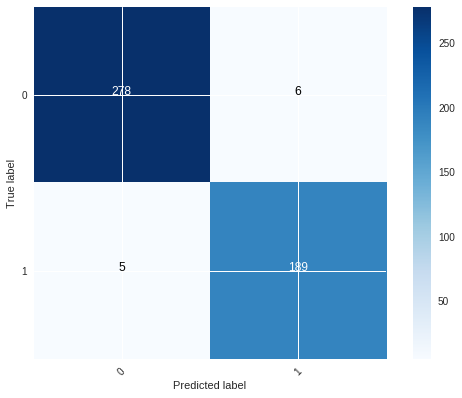

In [13]:

class_names = [i for i in range (2)]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
  
  
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    '''    
    labels = classes
    #cm = confusion_matrix(y_test, pred, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    '''
    print(cm)
    print ('\n\n')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# In[ ]:


cnf_matrix = confusion_matrix(val_y, predictions)


# In[ ]:


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)

from sklearn import metrics
print ('\n\n')
print (metrics.classification_report(val_y,predictions))
print ('\n\n')

# Start building 2nd stage model 

In [60]:


'''
build 2nd stage model
# 雀屏中選
'''


train2_data = np.load(src_save+'train_data_DenseNet121_1_verification.npy')
train2_data.shape


'''
filter out defcet item from label
get  2nd stage train data and label data note: 2nd stage tarin data will use conv

'''



failure_list = train_label_data !=0
print (sum(failure_list))  # 正常: 1018, 2386-1018 = 1368
failure_list

# prepare data for 2nd stage prediction (using test_data with slicing out those to be classified as defect)
train2_data_2 = train2_data[failure_list]
print (train2_data_2.shape)



train_label_data_2 = train_label_data[failure_list]
print (train_label_data_2.shape)

'''
2nd stage label data is 1 to 11
 needs to adgest to 0 - 10 for one hot encoding
'''
one_hot_train_label_data_2 = to_categorical(train_label_data_2 - 1)

one_hot_train_label_data_2.shape




train_x,val_x,train_y,val_y = train_test_split(train2_data_2,one_hot_train_label_data_2,test_size=0.2,shuffle=True)

# NOW Data ready for training



'''
model 6 is the best result model for nd stage
'''

def conv_block(ch, strides, activation= 'relu', padding='same',kernel_regularizer=regularizers.l1(0.05)):
    return Conv2D(ch,(3,3), strides=strides, activation= activation, padding =padding , kernel_regularizer= kernel_regularizer)

def build_model_6(ch=2):
    #inputs = Input((IMAGE_HEIGHT,IMAGE_WIDTH,ch))
    inputs = Input((1024,))



    x = Dense(512, activation='relu')(inputs)

    x =Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)

    x =Dropout(0.3)(x)

    x = Dense(128, activation='relu')(x)

    x =Dropout(0.3)(x)

    #x = Dense(64, activation='relu')(x)

    #x =Dropout(0.3)(x)


    outputs = Dense(11,activation='softmax')(x)



    model = Model(inputs= inputs, outputs=outputs)
    model.summary()

    return model



model = build_model_6()

model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])

#model_6 = load_model(src_1+'conv_for_defect_11_2_final.h5')


checkpoint = ModelCheckpoint(src_save+'conv_for_defect_11_2.h5')
earlystop = EarlyStopping(monitor='val_loss',  patience=10,  mode='auto')
callback_list = [checkpoint,earlystop]

model.fit(x=train_x, y=train_y, batch_size=32, epochs=300, verbose=1, callbacks=callback_list, validation_split=0.2, shuffle=True)

model.evaluate(val_x,val_y)

1368
(1368, 1024)
(1368,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 1024)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_48 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_49 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)          

[0.3826988424262861, 0.8649635040847055]

---

In [0]:

model.save(src_save+'2nd_stage_dense_final_verification.h5')


Confusion matrix, without normalization
[[ 6  0  0  1  0  0  0  0  0  0  0]
 [ 0 31  0  0  1  0  0  2  0  0  2]
 [ 0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  0  0]
 [ 0  1  0  0 87  0  0  0  0  0  0]
 [ 0  1  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0  0  0]
 [ 0  3  0  0  0  0  0 16  0  0  0]
 [ 0  0  0  0  0  0  0  0  6  0  0]
 [ 0  4  0  1  0  2  0  0  0 26  5]
 [ 0 10  0  1  1  1  0  0  0  1 20]]






             precision    recall  f1-score   support

          0       1.00      0.86      0.92         7
          1       0.62      0.86      0.72        36
          2       1.00      1.00      1.00         4
          3       0.88      1.00      0.94        23
          4       0.98      0.99      0.98        88
          5       0.77      0.91      0.83        11
          6       1.00      1.00      1.00         8
          7       0.89      0.84      0.86        19
          8       1.00      1.00      1.00         6
          9       0.96    

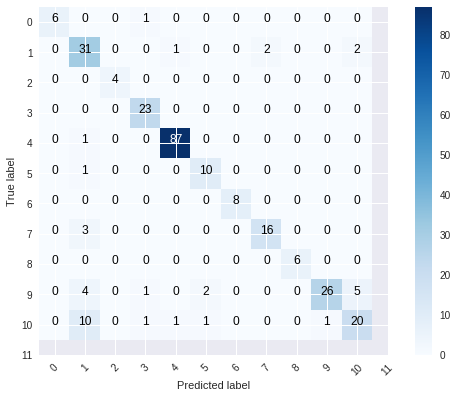

In [61]:

'''
plot confusion matrix
'''
class_names = [i for i in range (12)]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):


    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    '''
    labels = classes
    #cm = confusion_matrix(y_test, pred, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    '''
    print(cm)
    print ('\n\n')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# In[ ]:

predictions = np.argmax(model.predict(val_x),axis=1)

cnf_matrix = confusion_matrix(np.argmax(val_y,axis=1), predictions)


# In[ ]:


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)

from sklearn import metrics
print ('\n\n')
print (metrics.classification_report(np.argmax(val_y,axis=1), predictions))
print ('\n\n')

# Start Testing

In [62]:

"""# Starting doing Testing"""

'''
1st stage
import Data
import ast stage model - xgb
classfiication via xgb1
later wil sue 1st stage classification to filter out test data for 2nd stage classfiication
'''

test1_data = np.load(src_save+'test_data_DenseNet121_1_verification.npy')



with open (src_save+'xgb1_stage_1_DenseNet121_verification.pkl','rb') as handle:
  xgb_stage_1 = pickle.load(handle)

xgb_stage_1



pred_stage_1 = xgb_stage_1.predict(test1_data)

#predictions_stage_1 = [round(value) for value in pred_stage_1]

#print (len(predictions_stage_1))
print (pred_stage_1[:10])

# note: predict = 1 measn '正常' or non-dfect

failure_list= (pred_stage_1 == 0)



test2_data = np.load(src_save+'test_data_DenseNet121_1_verification.npy')
test2_data.shape


test2_data_2 = test2_data[failure_list]    # test_data2 = defect list in test data set (later will make inferefing )
test2_data_2.shape

model = load_model(src_save+'2nd_stage_dense_final_verification.h5')


pred_stage_2 = model.predict(test2_data_2)

#predictions_stage_1 = [round(value) for value in pred_stage_1]

print (pred_stage_2.shape)

pred_stage_2_2 = np.argmax(pred_stage_2,axis=1) + 1  # note 要加  1 回來 starts from 1 to12 (not 0 to 11)
print (pred_stage_2_2.shape)

print (pred_stage_2_2[:10])


'''
make submit csv
read sample test csv  from original add header 'img', 'label'
replace 'label' as first predict
change 0 to 20 (use 20 to distiguish from other label data, just means it is defect
change 1 to 0  (1 measn normal, needs to change back to category 0)
'''

# read test csv file
test_df = pd.read_csv(src_1+'test.csv')
test_df['label']= pred_stage_1
test_df.loc[test_df['label']==0,'label']=20
test_df.loc[test_df['label']==1,'label']=0



'''
replace defect rows with 2nd staget prediction
'''
test_df_2 =  test_df['label']
test_df_2[test_df_2 == 20] = pred_stage_2_2


test_df['label'] = test_df_2


'''
change form 0,11 to category name
'''

with open(src_1+'label_to_category.pkl', 'rb') as handle:
    label_to_category = pickle.load(handle)


test_df['label'].replace(label_to_category,inplace=True)
test_df

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0 0 0 1 0 1 0 0 0 0]
(302, 11)
(302,)
[ 5  5 11  5 11  6  4 10  5 10]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,img,label
0,0.jpg,defect5
1,1.jpg,defect5
2,2.jpg,defect11
3,3.jpg,norm
4,4.jpg,defect5
5,5.jpg,norm
6,6.jpg,defect11
7,7.jpg,defect6
8,8.jpg,defect4
9,9.jpg,defect10


In [0]:



# save csv file for submit (using 2  satge )

test_df.to_csv(src_1+'test_submit_2_st_0924_verification.csv', header=False,index=False)
